<a href="https://colab.research.google.com/github/subikkshas/PREPARE-ALL/blob/main/model_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.6 MB/s eta 0:00:00


In [105]:
### function to remove features
import pandas as pd
def remove_columns(df, feature_set='normal'):

    # Define base leakage columns to always remove
    base_leakage_cols = [
        "Sl No",
        "UPN_AI_dataset",
        # All Date columns
        "Date of Birth", "Date of Diagnosis", "Date of Remission_EOI",
        "Date of Completion of treatment", "Date of Relapse",
        "Date of Death ", "Date of Treatment abandonment/ Disease progresssion/Off protocol",
        "Date of Last FU",
        # Relapse & outcome details
        "Time-point of Relapse ", "Type of relapse", "Site of Relapse ",
        "Death", "Treatment death phase",
        "Treatment abandonment/Disease progresssion/Off protocol",
        "Current status at Last Follow up ", "Remission status _EOI"
    ]

    # Additional columns to remove for minimal feature set
    minimal_cols = [
        "Previous Treatment", "NCI Risk", "Lineage", "Bulky Disease",
        "CNS Disease", "Detail cytogenetics", "Provisional risk",
    ]

    # Combine columns based on feature_set parameter
    if feature_set == 'minimal':
        cols_to_remove = base_leakage_cols + minimal_cols
    else:  # 'normal' or any other value
        cols_to_remove = base_leakage_cols

    # Remove only columns that exist in the dataframe
    existing_cols_to_remove = [c for c in cols_to_remove if c in df.columns]
    df_clean = df.drop(columns=existing_cols_to_remove)

    return df_clean



### function to clean string columns
def clean_string_columns(df, columns_to_clean):
  existing_cols_to_clean = [col for col in columns_to_clean if col in df.columns]

  for col in existing_cols_to_clean:
      df[col] = df[col].astype("string").str.strip().str.lower()

  return df



### function to remove entry which are not in remission
def filter_remission_status(df):
  if 'Remission status _EOI' in df.columns:
    # Filter out 'not in remission' records (case-insensitive) but keep <NA>
    df_filter = df[df['Remission status _EOI'].astype(str).str.lower() != 'not in remission'].copy()
    print(f"Original dataset shape: {df.shape}")
    print(f"Filtered dataset shape: {df_filter.shape}")
    print(f"Number of rows removed: {df.shape[0] - df_filter.shape[0]}")
    return df_filter

  else:
    print("Column 'Remission status _EOI' not found in the DataFrame.")
    return df



### funtion to split the data
from sklearn.model_selection import train_test_split
def split_data(df, target_col="Relapsed", test_size=0.20, random_state=42, stratify=True):

    # Check if target column exists
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataframe")

    # Prepare features and target
    X = df.drop(columns=[target_col])
    y = df[target_col].astype("category").cat.codes  # Convert Yes/No to 0/1

    # Split data
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

    # Print summary
    print("Data split summary:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"Training set class distribution: {dict(zip(y_train.value_counts().index, y_train.value_counts().values))}")
    print(f"Test set class distribution: {dict(zip(y_test.value_counts().index, y_test.value_counts().values))}")

    return X_train, X_test, y_train, y_test



### function to load the data from drive
from google.colab import drive
import pandas as pd
import os

def load_train_test_data(load_path='/content/drive/MyDrive/test_data/'):
    # Mount Google Drive (if not already mounted)
    try:
        drive.mount('/content/drive')
        print("Google Drive mounted successfully.")
    except:
        print("Google Drive already mounted or mounting failed.")

    # Load the data files
    try:
        loaded_X_train = pd.read_csv(os.path.join(load_path, 'X_train.csv'))
        loaded_y_train = pd.read_csv(os.path.join(load_path, 'y_train.csv'))
        loaded_X_test = pd.read_csv(os.path.join(load_path, 'X_test.csv'))
        loaded_y_test = pd.read_csv(os.path.join(load_path, 'y_test.csv'))

        print("Data loaded successfully!")
        print(f"X_train shape: {loaded_X_train.shape}")
        print(f"y_train shape: {loaded_y_train.shape}")
        print(f"X_test shape: {loaded_X_test.shape}")
        print(f"y_test shape: {loaded_y_test.shape}")

        return loaded_X_train, loaded_y_train, loaded_X_test, loaded_y_test

    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None, None



### function for imputation
from sklearn.impute import SimpleImputer
import pandas as pd
from typing import List, Tuple, Dict

def impute_train_test(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    categorical_cols: List[str],
    numeric_cols: List[str],
    numeric_strategy: str = "median",
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, SimpleImputer]]:
    """
    Fit imputers on X_train and transform both X_train and X_test.
    - Categorical: most_frequent
    - Numeric: numeric_strategy (default median)

    Returns:
        X_train_imp, X_test_imp, {'cat': cat_imputer, 'num': num_imputer}
    """
    # Safety: work on copies
    X_train_imp = X_train.copy()
    X_test_imp  = X_test.copy()

    # Filter to existing columns (avoids KeyErrors if lists have extras)
    cat_cols_exist = [c for c in categorical_cols if c in X_train.columns]
    num_cols_exist = [c for c in numeric_cols if c in X_train.columns]

    # Define imputers
    cat_imputer = SimpleImputer(strategy="most_frequent")
    num_imputer = SimpleImputer(strategy=numeric_strategy)

    # --- Fit on TRAIN ---
    if cat_cols_exist:
        X_train_imp[cat_cols_exist] = cat_imputer.fit_transform(X_train_imp[cat_cols_exist])
        # Cast back to object to keep them categorical-like
        for c in cat_cols_exist:
            X_train_imp[c] = X_train_imp[c].astype(object)

    if num_cols_exist:
        X_train_imp[num_cols_exist] = num_imputer.fit_transform(X_train_imp[num_cols_exist])
        # Ensure numeric dtype
        for c in num_cols_exist:
            X_train_imp[c] = pd.to_numeric(X_train_imp[c], errors="coerce")

    # --- Transform TEST with the same fitted imputers ---
    # If test is missing some listed columns, skip them gracefully
    cat_cols_test = [c for c in cat_cols_exist if c in X_test_imp.columns]
    num_cols_test = [c for c in num_cols_exist if c in X_test_imp.columns]

    if cat_cols_test:
        X_test_imp[cat_cols_test] = cat_imputer.transform(X_test_imp[cat_cols_test])
        for c in cat_cols_test:
            X_test_imp[c] = X_test_imp[c].astype(object)

    if num_cols_test:
        X_test_imp[num_cols_test] = num_imputer.transform(X_test_imp[num_cols_test])
        for c in num_cols_test:
            X_test_imp[c] = pd.to_numeric(X_test_imp[c], errors="coerce")

    imputers = {"cat": cat_imputer, "num": num_imputer}
    return X_train_imp, X_test_imp, imputers



### function for encoding
from typing import Dict, List, Tuple, Union
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def encode_data_simple(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series = None,
    y_test: pd.Series = None,
    custom_mapping: Dict[str, Dict[str, int]] = None
):
    """
    Simplified version using manual one-hot encoding to avoid sklearn issues.
    """

    # Default mapping
    default_mapping = {
        'Previous Treatment': {'no': 0, 'yes': 1},
        'NCI Risk': {'standard': 0, 'high': 1},
        'Sex': {'male': 0, 'female': 1},
        'Lineage': {'b': 0, 't': 1},
        'Bulky Disease': {'no': 0, 'yes': 1},
        'Prednisolone Response': {'good': 0, 'poor': 1},
        'CNS Disease': {'no': 0, 'yes': 1},
        'Cytogenetic groups ': {'non-high risk': 1, 'not required': 2, 'high risk': 3},
        'Provisional risk': {'standard': 0, 'intermediate': 1, 'high': 2, 't': 3},
        'MRD Status_EOI': {'negative': 1, 'not required': 2, 'positive': 3},
        'Final Risk ': {'standard': 0, 'intermediate': 1, 'high': 2, 't': 3},
        'Relapsed': {'no': 0, 'yes': 1}
    }

    mapping = custom_mapping if custom_mapping is not None else default_mapping
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    encoding_info = {'label_mapping': {}}

    # Encode target
    y_train_encoded, y_test_encoded = None, None
    if y_train is not None and y_test is not None:
        if 'Relapsed' in mapping:
            # Create mapping function
            relapsed_map = mapping['Relapsed']
            y_train_encoded = y_train.map(lambda x: relapsed_map.get(str(x).lower(), 0)).astype(int)
            y_test_encoded = y_test.map(lambda x: relapsed_map.get(str(x).lower(), 0)).astype(int)
            encoding_info['label_mapping']['Relapsed'] = mapping['Relapsed']

    # Manual one-hot encoding for 'Detail cytogenetics'
    if 'Detail cytogenetics' in X_train_encoded.columns:
        try:
            # Get all unique categories from training data
            unique_categories = X_train_encoded['Detail cytogenetics'].fillna('unknown').astype(str).unique()

            # Create one-hot encoded columns for training data
            for category in unique_categories:
                col_name = f"cytogenetics_{category}"
                X_train_encoded[col_name] = (X_train_encoded['Detail cytogenetics'].fillna('unknown').astype(str) == category).astype(int)

            # Create same columns for test data (some might be all zeros)
            for category in unique_categories:
                col_name = f"cytogenetics_{category}"
                X_test_encoded[col_name] = (X_test_encoded['Detail cytogenetics'].fillna('unknown').astype(str) == category).astype(int)

            # Drop original column
            X_train_encoded = X_train_encoded.drop('Detail cytogenetics', axis=1)
            X_test_encoded = X_test_encoded.drop('Detail cytogenetics', axis=1)

            encoding_info['onehot_features'] = [f"cytogenetics_{cat}" for cat in unique_categories]

        except Exception as e:
            print(f"Manual one-hot encoding failed: {e}")
            # Fallback to label encoding
            X_train_encoded['Detail cytogenetics'] = X_train_encoded['Detail cytogenetics'].astype('category').cat.codes
            X_test_encoded['Detail cytogenetics'] = X_test_encoded['Detail cytogenetics'].astype('category').cat.codes

    # Apply label encoding to other columns
    for column, value_map in mapping.items():
        if column != 'Relapsed' and column in X_train_encoded.columns:
            # Create a mapping function for this specific column
            def map_value(x, mapping_dict=value_map):
                x_str = str(x).lower().strip() if pd.notna(x) else 'unknown'
                return mapping_dict.get(x_str, 0)  # Default to 0 for unknown values

            X_train_encoded[column] = X_train_encoded[column].apply(map_value)
            if column in X_test_encoded.columns:
                X_test_encoded[column] = X_test_encoded[column].apply(map_value)
            encoding_info['label_mapping'][column] = value_map

    # Handle any remaining categorical columns
    categorical_cols = X_train_encoded.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        if col not in encoding_info['label_mapping']:
            X_train_encoded[col] = X_train_encoded[col].astype('category').cat.codes
            X_test_encoded[col] = X_test_encoded[col].astype('category').cat.codes
            encoding_info['label_mapping'][col] = 'categorical_encoding_auto'

    # Ensure all columns are numeric
    X_train_encoded = X_train_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)
    X_test_encoded = X_test_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

    print("Encoding completed successfully!")
    print(f"X_train shape after encoding: {X_train_encoded.shape}")
    print(f"X_test shape after encoding: {X_test_encoded.shape}")

    return X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded, encoding_info



import optuna
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (average_precision_score, precision_recall_curve,
                           f1_score, recall_score, precision_score,
                           classification_report, confusion_matrix, roc_auc_score)



### function for optimization + training
from sklearn.metrics import average_precision_score

def tune_with_optuna(X_train, y_train, n_trials=50):

    # Ensure y_train is a Series, not DataFrame
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.iloc[:, 0]

    pos = sum(y_train == 1)
    neg = sum(y_train == 0)
    scale_pos_weight = neg / pos  # imbalance handling
    # print(scale_pos_weight)

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 800),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "scale_pos_weight": scale_pos_weight,
            "random_state": 42,
            "use_label_encoder": False,
            "eval_metric": "logloss",
        }
        model = XGBClassifier(**params)
        model.fit(X_train, y_train)

        # Get predicted probabilities
        y_probs = model.predict_proba(X_train)[:, 1]

        # Optimize AUCPR
        return average_precision_score(y_train, y_probs)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_model = XGBClassifier(**study.best_params)
    best_model.fit(X_train, y_train)

    return best_model, study.best_params



### function for threshold tuning
def tune_threshold(model, X_val, y_val):
    y_probs = model.predict_proba(X_val)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    return best_threshold, f1_scores[best_idx]



### function for evaluation
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)

def evaluate_model(model, X_test, y_test, threshold=0.5):
    # Probabilities
    y_probs = model.predict_proba(X_test)[:, 1]

    # Apply threshold
    y_pred = (y_probs >= threshold).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_probs)
    cm = confusion_matrix(y_test, y_pred)

    # Print neatly
    print("=== Evaluation Metrics (Summary) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    return



### function for Precision - Recall curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, roc_auc_score

def compare_thresholds(model, X_test, y_test, thresholds=[0.5, 0.55]):
    y_probs = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresh = precision_recall_curve(y_test, y_probs)

    # Plot PR curve
    plt.figure(figsize=(8,6))
    plt.plot(recalls, precisions, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve with Threshold Markers")

    # Mark chosen thresholds
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        plt.scatter(rec, prec, marker="o", label=f"Threshold={t}")

    plt.legend()
    plt.show()

    # Print metrics comparison
    results = []
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        results.append({
            "Threshold": t,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_probs)
        })
    return pd.DataFrame(results)



### function for feature imp
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
import pandas as pd

# === Feature Importance (Top 10) ===
def plot_feature_importance(model, feature_names, top_n=10):
    # Get feature importance from trained XGBoost model
    importance = model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'feature': list(importance.keys()),
        'importance': list(importance.values())
    }).sort_values(by='importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['feature'][::-1], importance_df['importance'][::-1])
    plt.xlabel("Gain Importance")
    plt.title(f"Top {top_n} Features (XGBoost Gain Importance)")
    plt.show()

# Example usage:
# plot_feature_importance(best_model, X_train_encoded.columns)



### function for SHAP
def plot_shap_summary(model, X_train, sample_size=500):
    # Take a sample to speed up SHAP
    if X_train.shape[0] > sample_size:
        X_sample = X_train.sample(sample_size, random_state=42)
    else:
        X_sample = X_train

    # Use TreeExplainer for XGBoost
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    # Summary plot (feature importance with SHAP values)
    shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=10)
    shap.summary_plot(shap_values, X_sample)  # beeswarm plot


# Example usage:
# plot_shap_summary(best_model, X_train_encoded)



---



In [8]:
file_path = "/content/Icicle Pre trial AI paper dataset_anonymised_April 2025.xlsx"
df = pd.read_excel(file_path)

In [9]:
'''df_clean = remove_columns(df, feature_set='minimal')
print(df_clean.columns.tolist())'''

"df_clean = remove_columns(df, feature_set='minimal')\nprint(df_clean.columns.tolist())"

In [10]:
df_clean = remove_columns(df, feature_set='normal')
print(df_clean.columns.tolist())

['Previous Treatment', 'NCI Risk', 'Sex', 'Age', 'Lineage', 'Bulky Disease', 'Highest presenting WBC', 'Prednisolone Response', 'CNS Disease', 'Cytogenetic groups ', 'Detail cytogenetics', 'Provisional risk', 'MRD Status_EOI', 'Final Risk ', 'Relapsed']


In [11]:
df_clean = clean_string_columns(df_clean, ['Previous Treatment', 'NCI Risk', 'Sex', 'Lineage', 'Bulky Disease', 'Prednisolone Response', 'CNS Disease', 'Cytogenetic groups ', 'Detail cytogenetics', 'Provisional risk', 'MRD Status_EOI', 'Final Risk ', 'Relapsed'])

In [12]:
# remove entry which are not in remission
df_clean = filter_remission_status(df_clean)

Column 'Remission status _EOI' not found in the DataFrame.


In [17]:
# Get the indices of the test data
test_indices = loaded_X_test.index

# Extract training data by excluding test indices
X_train = df_clean.drop(test_indices).drop('Relapsed', axis=1)  # Replace 'target_column'
y_train = df_clean.drop(test_indices)['Relapsed']  # Replace 'target_column'

# Verify the reconstruction
print(f"Full data shape: {df_clean.shape}")
print(f"X_test shape: {loaded_X_test.shape}")
print(f"y_test shape: {loaded_y_test.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Total samples: {len(X_train) + len(loaded_X_test)} == {len(df_clean)}")

Full data shape: (2331, 15)
X_test shape: (467, 14)
y_test shape: (467, 1)
X_train shape: (1864, 14)
y_train shape: (1864,)
Total samples: 2331 == 2331


In [18]:
from google.colab import drive
import pandas as pd
import os

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the path to save the files in your Drive
# Using the same folder as the test data for consistency
save_path = '/content/drive/MyDrive/test_data/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save X_train and y_train to CSV files
X_train_path = os.path.join(save_path, 'X_train.csv')
y_train_path = os.path.join(save_path, 'y_train.csv')

X_train.to_csv(X_train_path, index=False)
y_train.to_csv(y_train_path, index=False)

print(f"X_train saved to: {X_train_path}")
print(f"y_train saved to: {y_train_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X_train saved to: /content/drive/MyDrive/test_data/X_train.csv
y_train saved to: /content/drive/MyDrive/test_data/y_train.csv


In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the files in your Drive
# You might want to create a specific folder for your data
save_path = '/content/drive/MyDrive/test_data/'

# Create the directory if it doesn't exist
import os
os.makedirs(save_path, exist_ok=True)

# Save X_test and y_test to CSV files
X_test_path = os.path.join(save_path, 'X_test.csv')
y_test_path = os.path.join(save_path, 'y_test.csv')

X_test.to_csv(X_test_path, index=False)
y_test.to_csv(y_test_path, index=False)

print(f"X_test saved to: {X_test_path}")
print(f"y_test saved to: {y_test_path}")

# --- Code to load the data back from Drive ---
# (You can run this in a new session or after a runtime restart)

# Mount Google Drive (if not already mounted)
# drive.mount('/content/drive')

# Define the path where the files are saved
# load_path = '/content/drive/MyDrive/test_data/' # Use the same path as save_path

# Load X_test and y_test from CSV files
# loaded_X_test = pd.read_csv(os.path.join(load_path, 'X_test.csv'))
# loaded_y_test = pd.read_csv(os.path.join(load_path, 'y_test.csv'))

# Display the loaded data (optional)
# print("\nLoaded X_test:")
# display(loaded_X_test.head())
# print("\nLoaded y_test:")
# display(loaded_y_test.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X_test saved to: /content/drive/MyDrive/test_data/X_test.csv
y_test saved to: /content/drive/MyDrive/test_data/y_test.csv




---



In [23]:
X_train, y_train, X_test, y_test = load_train_test_data()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Data loaded successfully!
X_train shape: (1864, 14)
y_train shape: (1864, 1)
X_test shape: (467, 14)
y_test shape: (467, 1)


In [24]:
# Define column types
categorical_cols = ['Previous Treatment', 'NCI Risk', 'Sex', 'Lineage', 'Bulky Disease', 'Prednisolone Response', 'CNS Disease', 'Cytogenetic groups ', 'Detail cytogenetics', 'Provisional risk', 'MRD Status_EOI', 'Final Risk ']
numeric_cols = ['Age', 'Highest presenting WBC']

# Apply safe imputation
X_train_imputed, X_test_imputed, fitted_imputers = impute_train_test(
    X_train,
    X_test,
    categorical_cols,
    numeric_cols,
    numeric_strategy="median"
)

# The fitted imputers can be saved and reused for new patient data

Missing values in X_train_imputed:
Previous Treatment        0
NCI Risk                  0
Sex                       0
Age                       0
Lineage                   0
Bulky Disease             0
Highest presenting WBC    0
Prednisolone Response     0
CNS Disease               0
Cytogenetic groups        0
Detail cytogenetics       0
Provisional risk          0
MRD Status_EOI            0
Final Risk                0
dtype: int64

Missing values in X_test_imputed:
Previous Treatment        0
NCI Risk                  0
Sex                       0
Age                       0
Lineage                   0
Bulky Disease             0
Highest presenting WBC    0
Prednisolone Response     0
CNS Disease               0
Cytogenetic groups        0
Detail cytogenetics       0
Provisional risk          0
MRD Status_EOI            0
Final Risk                0
dtype: int64

Missing values in y_train:
Relapsed    0
dtype: int64

Missing values in y_test:
0    0
dtype: int64


In [39]:
 X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded, encoding_info = encode_data(
        X_train_imputed, X_test_imputed, y_train, y_test
    )

Encoding completed successfully!
X_train shape after encoding: (1864, 14)
X_test shape after encoding: (467, 14)


In [48]:
print(X_train_imputed['Detail cytogenetics'].unique())

['etv6-runx1' 'high hyperdiploidy' 'b-other' 'hypodiploidy' 'tcf3-pbx1'
 'bcr-abl1' 'kmt2a rearranged' 'iamp21' 'tcf3-hlf' 'not required'
 'near triploidy/tetraploidy' 'tetraploidy' 'near triploidy']


In [84]:
print(loaded_y_test['0'].unique())

[0 1]


In [81]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded, encoding_info = encode_data_simple(
    X_train_imputed, X_test_imputed, y_train, loaded_y_test
)

Encoding completed successfully!
X_train shape after encoding: (1864, 26)
X_test shape after encoding: (467, 26)


In [82]:
print(X_train_encoded.dtypes)
print(X_test_encoded.dtypes)
print(y_train_encoded.dtypes)
print(y_test_encoded.dtypes)

Previous Treatment                           int64
NCI Risk                                     int64
Sex                                          int64
Age                                        float64
Lineage                                      int64
Bulky Disease                                int64
Highest presenting WBC                     float64
Prednisolone Response                        int64
CNS Disease                                  int64
Cytogenetic groups                           int64
Provisional risk                             int64
MRD Status_EOI                               int64
Final Risk                                   int64
cytogenetics_etv6-runx1                      int64
cytogenetics_high hyperdiploidy              int64
cytogenetics_b-other                         int64
cytogenetics_hypodiploidy                    int64
cytogenetics_tcf3-pbx1                       int64
cytogenetics_bcr-abl1                        int64
cytogenetics_kmt2a rearranged  

In [61]:
print(y_train_encoded['Relapsed'].unique())
print(y_train_encoded['Relapsed'].dtype)

[0 1]
int64


In [107]:
# Ensure y_train is a Series, not DataFrame
if isinstance(y_train_encoded, pd.DataFrame):
    y_train = y_train_encoded.iloc[:, 0]

pos = sum(y_train == 1)
neg = sum(y_train == 0)
scale_pos_weight = neg / pos  # imbalance handling
print(scale_pos_weight)

3.2076749435665914


In [64]:
# Step 1: Train + Tune
best_model, best_params = tune_with_optuna(X_train_encoded, y_train_encoded, n_trials=50)

[I 2025-09-12 09:22:08,369] A new study created in memory with name: no-name-bb1911bc-1bbf-489b-93ac-234b563f277e
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:22:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-12 09:22:09,052] Trial 0 finished with value: 0.670686964117648 and parameters: {'n_estimators': 380, 'max_depth': 8, 'learning_rate': 0.2517595450504204, 'subsample': 0.6946674526267995, 'colsample_bytree': 0.6052401572184014, 'gamma': 1.6880089253700499, 'reg_lambda': 9.911550794675035, 'reg_alpha': 0.45491692063076355, 'min_child_weight': 10}. Best is trial 0 with value: 0.670686964117648.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:22:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-12 09:22:09,888] T

In [104]:
print(best_params)

{'n_estimators': 462, 'max_depth': 10, 'learning_rate': 0.28177372155949143, 'subsample': 0.7415459634574787, 'colsample_bytree': 0.9748968625790161, 'gamma': 0.014283210407959473, 'reg_lambda': 1.8272791512341529, 'reg_alpha': 0.37228550161353985, 'min_child_weight': 3}


In [87]:
best_threshold, best_f1 = tune_threshold(best_model, X_test_encoded, loaded_y_test)
print(f"Best Threshold: {best_threshold}")
print(f"Best F1-Score: {best_f1}")

Best Threshold: 0.5505581498146057
Best F1-Score: 0.8374379300641119


In [ ]:
# Best Threshold: 0.5505581498146057
# Best F1-Score: 0.8374379300641119

In [94]:
# Step 3: Evaluation
evaluate_model(best_model, X_test_encoded, loaded_y_test, best_threshold)

'''print("Best Params:", best_params)
print("Best Threshold:", best_threshold)
print("Classification Report:\n", report)
print("ROC-AUC:", auc)'''

=== Evaluation Metrics (Summary) ===
Accuracy : 0.9293
Precision: 0.9444
Recall   : 0.7522
F1-score : 0.8374
ROC AUC  : 0.8778

Confusion Matrix:
[[349   5]
 [ 28  85]]


'print("Best Params:", best_params)\nprint("Best Threshold:", best_threshold)\nprint("Classification Report:\n", report)\nprint("ROC-AUC:", auc)'

In [92]:
evaluate_model(best_model, X_train_encoded, y_train_encoded, best_threshold)

=== Evaluation Metrics (Summary) ===
Accuracy : 0.9866
Precision: 0.9883
Recall   : 0.9549
F1-score : 0.9713
ROC AUC  : 0.9995

Confusion Matrix:
[[1416    5]
 [  20  423]]


In [101]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
# You can create a specific folder for models if you like
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename = 'best_xgboost_model.joblib'
model_path = os.path.join(save_path, model_filename)

# Save the model
joblib.dump(best_model, model_path)

print(f"Best model saved to: {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best model saved to: /content/drive/MyDrive/saved_models/best_xgboost_model.joblib


In [102]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to the saved model in your Drive
load_path = '/content/drive/MyDrive/saved_models/'
model_filename = 'best_xgboost_model.joblib'
model_path = os.path.join(load_path, model_filename)

# Load the model
try:
    loaded_model = joblib.load(model_path)
    print(f"Model loaded successfully from: {model_path}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")

# You can now use 'loaded_model' for predictions or further analysis
# For example: loaded_model.predict(X_test_encoded)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Model loaded successfully from: /content/drive/MyDrive/saved_models/best_xgboost_model.joblib


In [103]:
evaluate_model(loaded_model, X_test_encoded, loaded_y_test, best_threshold)

=== Evaluation Metrics (Summary) ===
Accuracy : 0.9293
Precision: 0.9444
Recall   : 0.7522
F1-score : 0.8374
ROC AUC  : 0.8778

Confusion Matrix:
[[349   5]
 [ 28  85]]


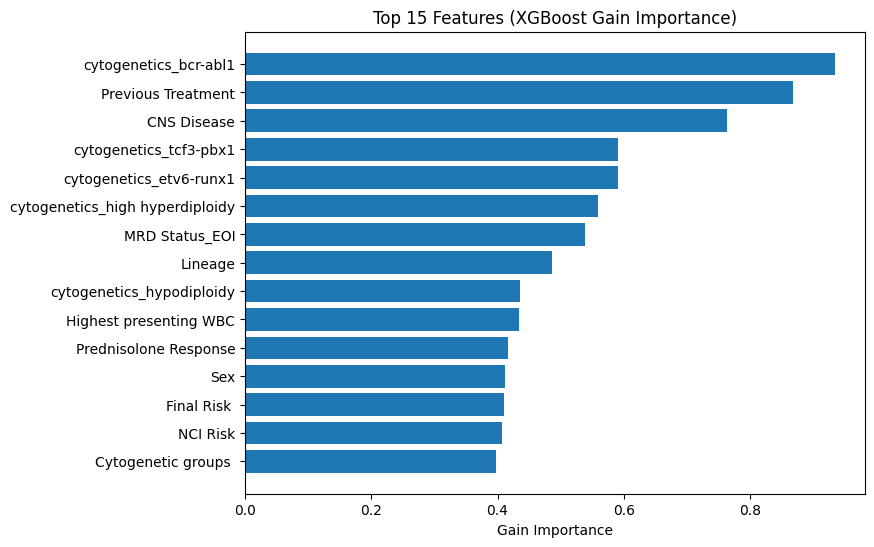

In [99]:
plot_feature_importance(best_model, X_train_encoded.columns, top_n=15)

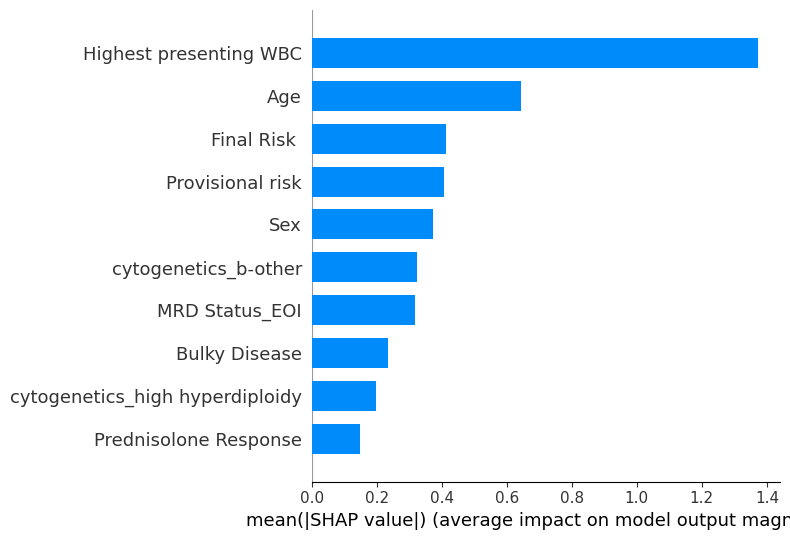

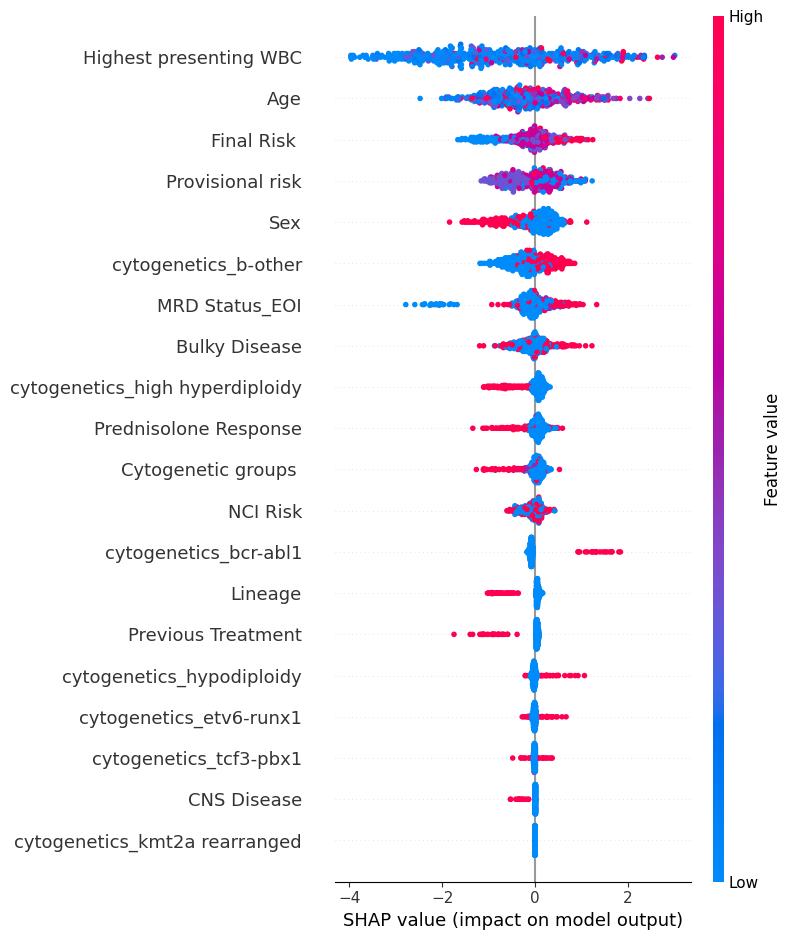

In [100]:
plot_shap_summary(best_model, X_train_encoded)

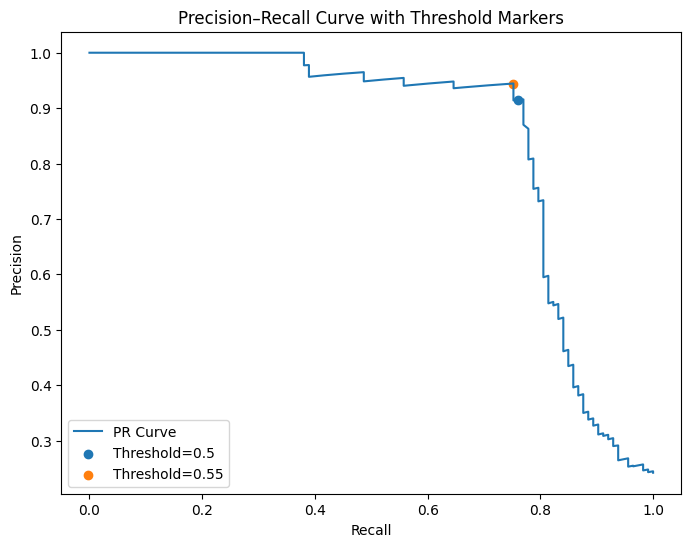

   Threshold  Accuracy  Precision    Recall        F1   ROC AUC
0       0.50  0.925054   0.914894  0.761062  0.830918  0.877806
1       0.55  0.929336   0.944444  0.752212  0.837438  0.877806


In [96]:
metrics_comparison = compare_thresholds(best_model, X_test_encoded, loaded_y_test, thresholds=[0.5, 0.55])
print(metrics_comparison)